<a href="https://www.kaggle.com/jasonjarosz/heart-disease-uci?scriptVersionId=85656993" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Source data & detailed info on the dataset: https://www.kaggle.com/ronitf/heart-disease-uci

This patient dataset includes 13 different medical features (age, gender, test results, etc.) along with whether or not the patient was diagnosed with heart disease. The goal of the analysis is to construct a predictive machine learning model using this data that can make a prediction of whether or not that patient has heart disease.

# **Table of Contents**

[Imports](#Imports)

[Initial EDA w/Pandas](#Initial-EDA-w/Pandas)

[Binary Classification w/Logistic Regression](#Binary-Classification-w/Logistic-Regression)

[Evaluating the Model](#Evaluating-the-Model)

[Final Logistic Regression Model](#Final-Logistic-Regression-Model)

# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# This import & for loop are needed to access the data file on Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-disease-uci/heart.csv


# Initial EDA w/Pandas

In [2]:
# Create DataFrame from .csv file
df = pd.read_csv('/kaggle/input/heart-disease-uci/heart.csv')

# Get an idea of what the data look like
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None


In [4]:
print(df.describe())

              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.9051

# Binary Classification w/Logistic Regression

Since this is a binary classification problem, logistic regression would be the first machine learning model that comes to mind.

Since this is a model that would likely be used as part of a diagnosis, recall is possibly the most important metric to examine. Since this is for heart disease, the model doesn't suffer from the same massive drawbacks of a false positive result as a cancer diagnostic tool would (that's a case where a very high ROC AUC score would be desirable).

In [5]:
# Select all rows, and all columns except 'target'
X = df.loc[:, 'age':'thal']

# Select 'target' column
y = df['target']

# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.32, 
                                                    random_state=1,
                                                    stratify=y)

'''
The default solver, 'lbfgs', would not converge given the data.
Through experimentation, the solvers that would converge were
'liblinear' and 'newton-cg'. We'll evaluate these two over 10-fold
cross-validation.
'''

# Create list of C params to check
c_params = [i/50 for i in range(1, 51)]

# Set log reg parameters
params = {'solver': ['liblinear','newton-cg'],
          'C': c_params}

# Perform 5-fold GridSearchCV w/log reg and no scaling
logreg_gridcv_ns = GridSearchCV(LogisticRegression(),
                                param_grid=params,
                                cv=10,
                                scoring='recall',
                                n_jobs=-1)

# Fit the data
logreg_gridcv_ns.fit(X_train, y_train)

# Generate predictions on the test set
y_pred = logreg_gridcv_ns.predict(X_test)

print(f'Log reg best params: {logreg_gridcv_ns.best_params_}')
print(f'Log reg accuracy: {accuracy_score(y_test, y_pred)}\n')

# Create a log reg classifier using the best estimator from GridSearchCV
optimal_log_reg_ns = logreg_gridcv_ns.best_estimator_

# Predict on the test set using the optimal classifier
y_pred = optimal_log_reg_ns.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

Log reg best params: {'C': 0.08, 'solver': 'liblinear'}
Log reg accuracy: 0.865979381443299

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        44
           1       0.86      0.91      0.88        53

    accuracy                           0.87        97
   macro avg       0.87      0.86      0.86        97
weighted avg       0.87      0.87      0.87        97



The model was tested with and without `train_test_split` stratification. With stratification, the precision, recall, and f1-score scores on the classification report increased noticeably. The weighted averages of all 3 increased from approx. 0.79 to 0.87. Stratification resulted in the accuracy score decreasing by approx. 0.10.

The two solvers ('liblinear' and 'newton-cg') used to accomplish the logistic regression are robust to unscaled datasets per sklearn's documentation (read more here: https://scikit-learn.org/dev/modules/linear_model.html#logistic-regression), so we will not scale the data in this instance.

Let's visually look at our model to make sure we aren't over/underfitting our data.

# Evaluating the Model

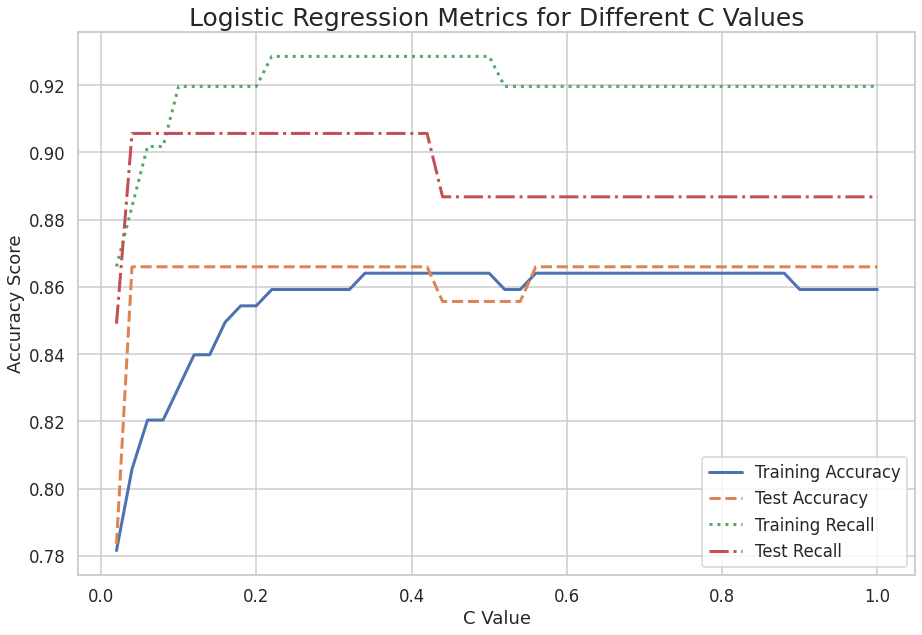

In [6]:
'''
Since the data is being regularized, it'd be a good idea
to compare accuracy values for the train and test sets
across the range of C values to look at where overfitting
occurs.
'''

# Create lists to store scores for each C value
train_acc_scores = []
test_acc_scores = []
train_recall_scores = []
test_recall_scores = []

# Iterate over the list of C values and compute their metrics 
for c in c_params:
    
    # Instantiate the model
    logreg = LogisticRegression(solver='liblinear', C=c)
    
    # Fit the data
    logreg.fit(X_train, y_train)
    
    # Make predictions on the data
    y_train_pred = logreg.predict(X_train)
    y_test_pred = logreg.predict(X_test)
    
    # Generate scores
    train_acc_score = accuracy_score(y_train, y_train_pred)
    test_acc_score = accuracy_score(y_test, y_test_pred)
    train_recall_score = recall_score(y_train, y_train_pred)
    test_recall_score = recall_score(y_test, y_test_pred)
    
    # Save the scores to their respective lists
    train_acc_scores.append(train_acc_score)
    test_acc_scores.append(test_acc_score)
    train_recall_scores.append(train_recall_score)
    test_recall_scores.append(test_recall_score)
    
# Create plot of train & test metrics for different C values
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('deep')

fig = plt.figure(figsize=(15, 10))
# Accuracy plots
plt.plot(c_params,
         train_acc_scores,
         label='Training Accuracy',
         linestyle='solid',
         linewidth=3)
plt.plot(c_params,
         test_acc_scores,
         label='Test Accuracy',
         linestyle='dashed',
         linewidth=3)
# Recall plots
plt.plot(c_params,
         train_recall_scores,
         label='Training Recall',
         linestyle='dotted',
         linewidth=3)
plt.plot(c_params,
         test_recall_scores,
         label='Test Recall',
         linestyle='dashdot',
         linewidth=3)
plt.title('Logistic Regression Metrics for Different C Values', size=25)
plt.xlabel('C Value')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

The C parameter returned by `GridSearchCV` (0.1) was not the best choice! Since we set GridSearchCV to optimize for recall, it appears it was overzealous in classifying the positive class and had a poor false positive rate. It maximized recall but at a huge cost to the training accuracy. C = 0.1 is a significant amount of regularization, which can negatively impact accuracy due to overgeneralizing the data. 

At values of C >= 0.25, this model fits the data well, without suffering from much overfitting or underfitting. After looking closely at the plot, the best choice for the C parameter would be around 0.35.

# Final Logistic Regression Model

Let's build the final model and gather all its metrics.

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        44
           1       0.86      0.91      0.88        53

    accuracy                           0.87        97
   macro avg       0.87      0.86      0.86        97
weighted avg       0.87      0.87      0.87        97

AUC Score: 0.9279588336192109


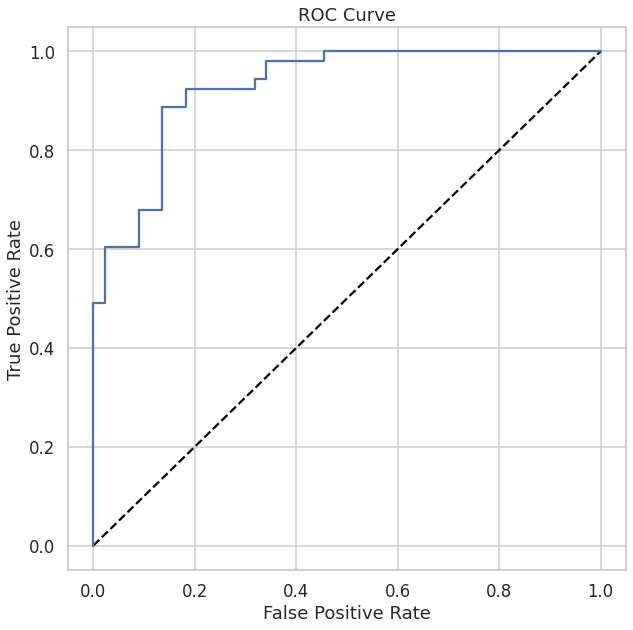

In [7]:
# Instantiate the model
final_logreg_model = LogisticRegression(solver='liblinear', C=0.35)

# Fit the data & make predictions
final_logreg_model.fit(X_train, y_train)
final_y_preds = final_logreg_model.predict(X_test)
final_y_pred_proba = final_logreg_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, final_y_preds))
print(f'AUC Score: {roc_auc_score(y_test, final_y_pred_proba)}')

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, final_y_pred_proba)

# Plot ROC curve
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('deep')

fig = plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

This model is decent but it might be possible to improve it. To tune it further we could try using GridSearchCV to optimize for other parameters. We could also try a different classifier, such as a random forest or a support vector machine. The source dataset only has a few hundred rows, so we would not expect a neural net to perform well on it.